## Dependencies

In [1]:
import warnings, math, json
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import tensorflow_addons as tfa
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from transformers import TFAutoModelForSequenceClassification, TFAutoModel, AutoTokenizer
from commonlit_scripts import *


seed = 0
seed_everything(seed)
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 150)

### Hardware configuration

In [2]:
strategy, tpu = get_strategy()
AUTO = tf.data.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Running on TPU grpc://10.0.0.2:8470
REPLICAS: 8


# Load data

In [3]:
train_filepath = '/kaggle/input/commonlitreadabilityprize/train.csv'
train = pd.read_csv(train_filepath)
print(f'Train samples: {len(train)}')
# removing unused columns
train.drop(['url_legal', 'license'], axis=1, inplace=True)
display(train.head())

Train samples: 2834


,id,excerpt,target,standard_error
0,c12129c31,"When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landsca...",-0.340259,0.464009
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewhat silent, her eyes resting on Dolly with a wistful, uncertain expression. She wanted to give the ch...",-0.315372,0.480805
2,b69ac6792,"As Roger had predicted, the snow departed as quickly as it came, and two days after their sleigh ride there was scarcely a vestige of white on the...",-0.580118,0.476676
3,dd1000b26,"And outside before the palace a great garden was walled round, filled full of stately fruit-trees, gray olives and sweet figs, and pomegranates, p...",-1.054013,0.450007
4,37c1b32fb,"Once upon a time there were Three Bears who lived together in a house of their own in a wood. One of them was a Little, Small, Wee Bear; and one w...",0.247197,0.510845


# Model parameters

In [4]:
config = {
  "BATCH_SIZE": 8 * REPLICAS,
  "LEARNING_RATE": 1e-5 * REPLICAS,
  "EPOCHS": 100,
  "ES_PATIENCE": 30,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 1,
  "SEQ_LEN": 256,
  "BASE_MODEL": '/kaggle/input/huggingface-roberta/roberta-base/',
  "SEED": seed,
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

## Auxiliary functions

In [5]:
# Datasets utility functions
def custom_standardization(text, is_lower=True):
    if is_lower:
        text = text.lower() # if encoder is uncased
    text = text.strip()
    return text

def sample_target(features, target):
    mean, _, stddev = target
    sampled_target = tf.random.normal([], mean=tf.cast(mean, dtype=tf.float32), 
                                      stddev=tf.cast(stddev, dtype=tf.float32), dtype=tf.float32)
    return (features, (mean, sampled_target))

def aux_target(features, label):
    aux_label = [0]
    
    if label[0] >= 1.: # target
        aux_label = [2]
    elif label[0] > -1.: # target
        aux_label = [1]
        
    return (features, (label[0], label[1], aux_label))
    
def get_dataset(pandas_df, tokenizer, labeled=True, ordered=False, repeated=False, 
                is_sampled=False, batch_size=32, seq_len=128, is_lower=True):
    """
        Return a Tensorflow dataset ready for training or inference.
    """
    text = [custom_standardization(text, is_lower) for text in pandas_df['excerpt']]
    
    # Tokenize inputs
    tokenized_inputs = tokenizer(text, max_length=seq_len, truncation=True, 
                                 padding='max_length', return_tensors='tf')
    
    if labeled:
        dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': tokenized_inputs['input_ids'], 
                                                       'attention_mask': tokenized_inputs['attention_mask']}, 
                                                      (pandas_df['target'], pandas_df['target'], pandas_df['standard_error'])))
        
        if is_sampled:
            dataset = dataset.map(sample_target, num_parallel_calls=tf.data.AUTOTUNE)
            
        dataset = dataset.map(aux_target, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = tf.data.Dataset.from_tensor_slices({'input_ids': tokenized_inputs['input_ids'], 
                                                      'attention_mask': tokenized_inputs['attention_mask']})
        
    if repeated:
        dataset = dataset.repeat()
    if not ordered:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Model

In [6]:
def model_fn(encoder, seq_len=256):
    input_ids = L.Input(shape=(seq_len,), dtype=tf.int32, name='input_ids')
    input_attention_mask = L.Input(shape=(seq_len,), dtype=tf.int32, name='attention_mask')
    
    outputs = encoder({'input_ids': input_ids,  
                       'attention_mask': input_attention_mask})
    last_hidden_state = outputs['last_hidden_state']
    
    cls_token = last_hidden_state[:, 0, :]
    output = L.Dense(1, name='output')(cls_token)
    output_sample = L.Dense(1, name='output_sample')(cls_token)
    output_aux = L.Dense(3, activation='softmax', name='output_aux')(cls_token)
    
    model = Model(inputs=[input_ids, input_attention_mask], 
                  outputs=[output, output_sample, output_aux])

    optimizer = optimizers.Adam(lr=config['LEARNING_RATE'])
    model.compile(optimizer=optimizer, 
                  loss={'output': losses.MeanSquaredError(), 
                        'output_sample': losses.MeanSquaredError(), 
                        'output_aux': losses.SparseCategoricalCrossentropy()}, 
                  loss_weights={'output': 1., 
                                'output_sample': 1., 
                                'output_aux': 1.}, 
                  metrics={'output': metrics.RootMeanSquaredError(name='rmse'), 
                           'output_sample': metrics.RootMeanSquaredError(name='rmse'), 
                           'output_aux': metrics.SparseCategoricalAccuracy(name='acc')})
    return model


with strategy.scope():
    encoder = TFAutoModel.from_pretrained(config['BASE_MODEL'])
    # Freeze embeddings
    encoder.layers[0].embeddings.trainable = False
    model = model_fn(encoder, config['SEQ_LEN'])
    
model.summary()

Some layers from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   attention_mask[0][0]             
                                                                 input_ids[0][0]                  
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           tf_roberta_model[0][0]       

# Training

In [7]:
tokenizer = AutoTokenizer.from_pretrained(config['BASE_MODEL'])
skf = KFold(n_splits=config['N_FOLDS'], shuffle=True, random_state=seed)
oof_pred = []; oof_labels = []; history_list = []; oof_pred2 = []


for fold,(idxT, idxV) in enumerate(skf.split(train)):
    if fold >= config['N_USED_FOLDS']:
        break
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {len(idxT)} VALID: {len(idxV)}')
    
    # Model
    K.clear_session()
    with strategy.scope():
        encoder = TFAutoModel.from_pretrained(config['BASE_MODEL'])
        # Freeze embeddings
        encoder.layers[0].embeddings.trainable = False
        model = model_fn(encoder, seq_len=config['SEQ_LEN'])

    model_path = f'model_{fold}.h5'
    es = EarlyStopping(monitor='val_output_rmse', mode='min', 
                       patience=config['ES_PATIENCE'], restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_output_rmse', mode='min', 
                                 save_best_only=True, save_weights_only=True)

    # Train
    history = model.fit(x=get_dataset(train.loc[idxT], tokenizer, repeated=True, is_sampled=True, 
                                      batch_size=config['BATCH_SIZE'], seq_len=config['SEQ_LEN']), 
                        validation_data=get_dataset(train.loc[idxV], tokenizer, ordered=True, 
                                                    batch_size=config['BATCH_SIZE'], seq_len=config['SEQ_LEN']), 
                        steps_per_epoch=10, 
                        callbacks=[es, checkpoint], 
                        epochs=config['EPOCHS'],  
                        verbose=2).history

    history_list.append(history)
    # Save last model weights
    model.load_weights(model_path)

    # Results
    print(f"#### FOLD {fold+1} OOF RMSE = {np.min(history['val_output_rmse']):.4f}")
    print(f"#### FOLD {fold+1} OOF RMSE = {np.min(history['val_output_sample_rmse']):.4f} (sampled)")
    print(f"#### FOLD {fold+1} OOF ACC = {np.max(history['val_output_aux_acc']):.4f}")

    # OOF predictions
    valid_ds = get_dataset(train.loc[idxV], tokenizer, ordered=True, 
                           batch_size=config['BATCH_SIZE'], seq_len=config['SEQ_LEN'])
    oof_labels.append([target[0].numpy() for sample, target in iter(valid_ds.unbatch())])
    x_oof = valid_ds.map(lambda sample, target: sample)
    preds = model.predict(x_oof)
    oof_pred.append(preds[0])
    oof_pred2.append(preds[1])


FOLD: 1
TRAIN: 2267 VALID: 567


Some layers from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/100
10/10 - 89s - loss: 3.6843 - output_loss: 1.2254 - output_sample_loss: 1.5410 - output_aux_loss: 0.9179 - output_rmse: 1.1070 - output_sample_rmse: 1.2414 - output_aux_acc: 0.4875 - val_loss: 2.2173 - val_output_loss: 0.7718 - val_output_sample_loss: 0.7054 - val_output_aux_loss: 0.7400 - val_output_rmse: 0.8785 - val_output_sample_rmse: 0.8399 - val_output_aux_acc: 0.5291
Epoch 2/100
10/10 - 2s - loss: 2.3605 - output_loss: 0.7065 - output_sample_loss: 0.9787 - output_aux_loss: 0.6753 - output_rmse: 0.8406 - output_sample_rmse: 0.9893 - output_aux_acc: 0.6594 - val_loss: 1.7459 - val_output_loss: 0.5722 - val_output_sample_loss: 0.6478 - val_output_aux_loss: 0.5259 - val_output_rmse: 0.7565 - val_output_sample_rmse: 0.8049 - val_output_aux_acc: 0.8042
Epoch 3/100
10/10 - 2s - loss: 2.0238 - output_loss: 0.6256 - output_sample_loss: 0.8296 - output_aux_loss: 0.5686 - output_rmse: 0.7910 - output_sample_rmse: 0.9108 - output_aux_acc: 0.7766 - val_loss: 1.8315 - val_output_lo

## Model loss and metrics graph


FOLD: 1


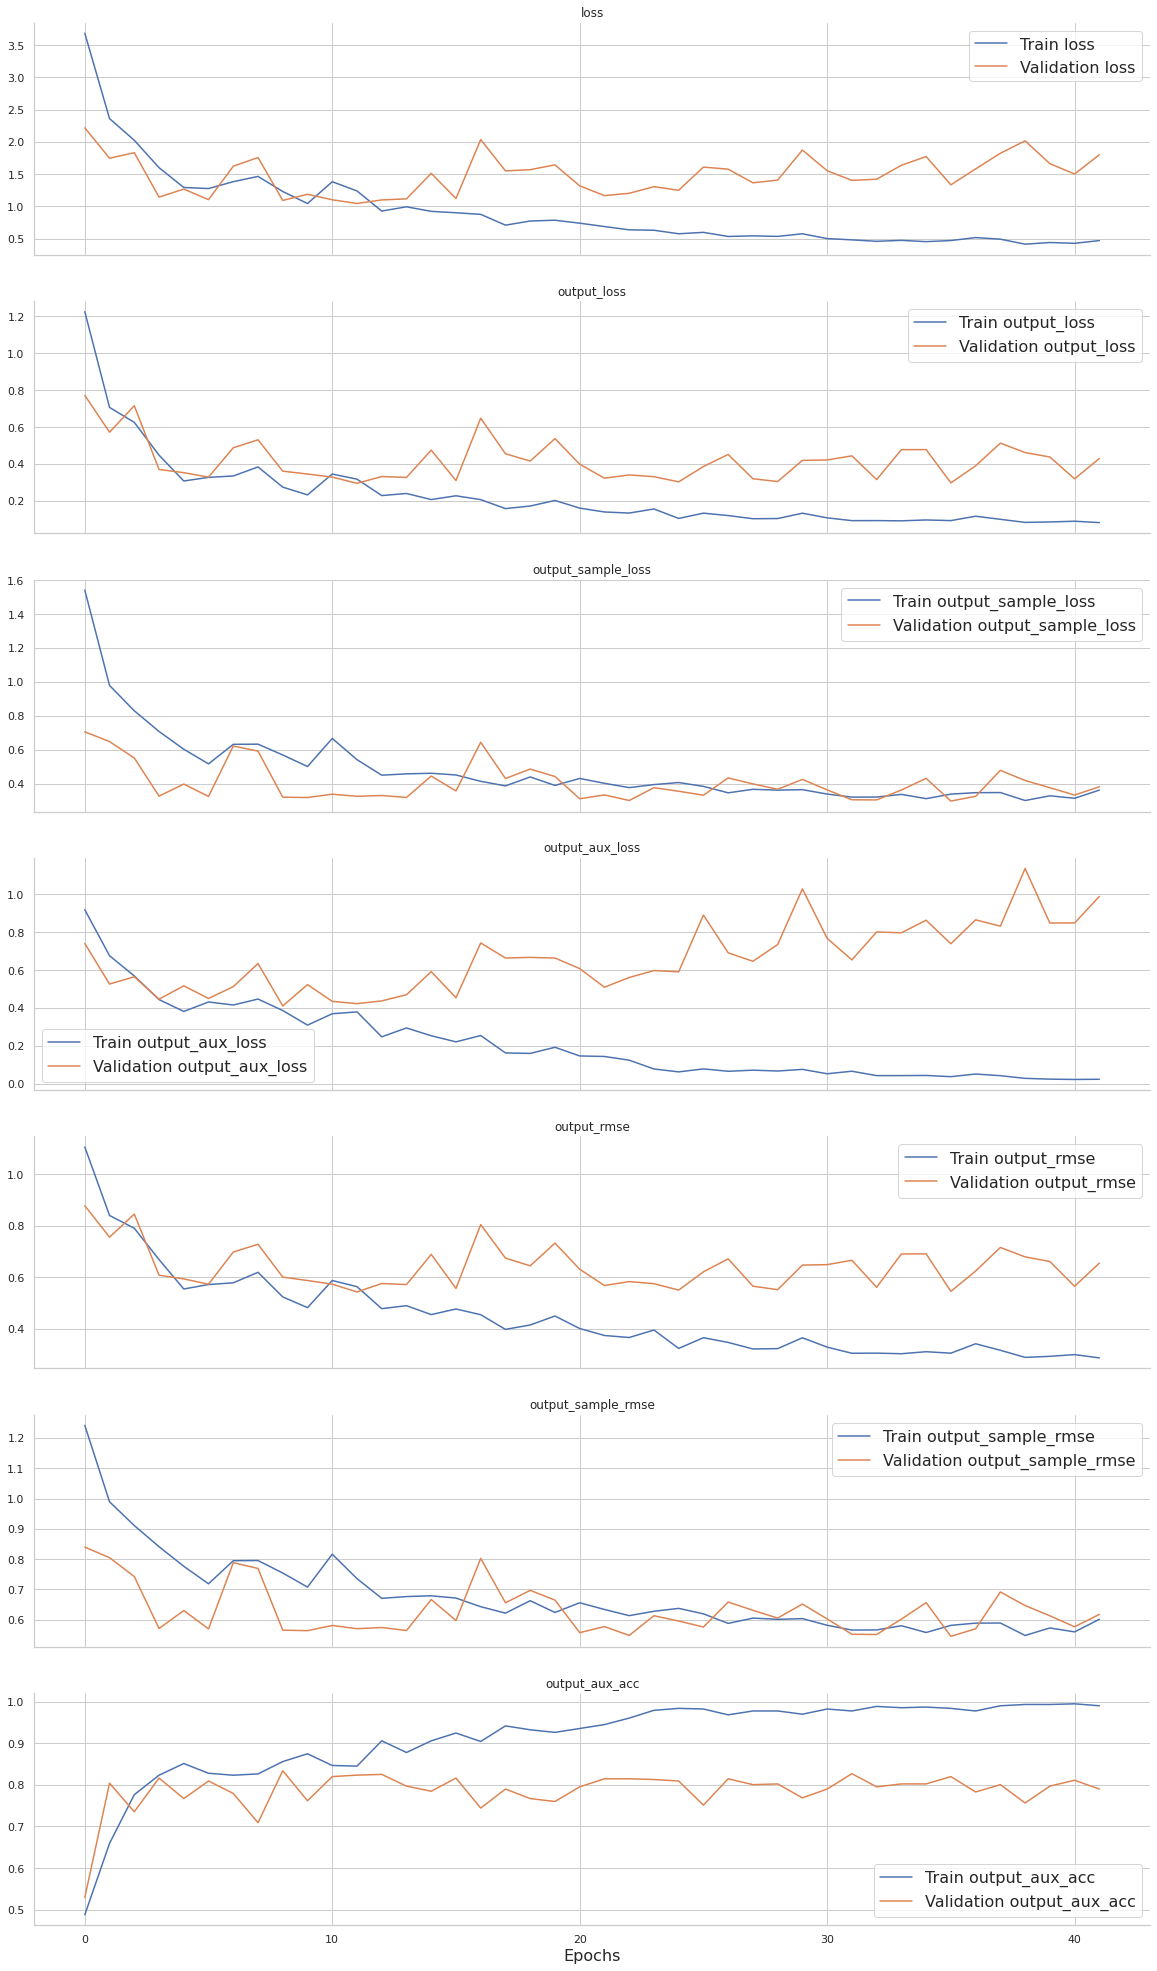

In [8]:
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    plot_metrics(history)

# Model evaluation

We are evaluating the model on the `OOF` predictions, it stands for `Out Of Fold`, since we are training using `K-Fold` our model will see all the data, and the correct way to evaluate each fold is by looking at the predictions that are not from that fold.

## OOF metrics

In [9]:
y_true = np.concatenate(oof_labels)
y_preds = np.concatenate(oof_pred)
y_preds2 = np.concatenate(oof_pred2)
y_preds_merge = np.mean([y_preds, y_preds2], axis=0)

for fold, history in enumerate(history_list):
    print(f"#### FOLD {fold+1} OOF RMSE = {np.min(history['val_output_rmse']):.4f}")
    print(f"#### FOLD {fold+1} OOF RMSE = {np.min(history['val_output_sample_rmse']):.4f} (sampled)")
    print(f"#### FOLD {fold+1} OOF ACC = {np.max(history['val_output_aux_acc']):.4f}")
    
print(f'OOF RMSE: {mean_squared_error(y_true, y_preds, squared=False):.4f}')
print(f'OOF RMSE: {mean_squared_error(y_true, y_preds2, squared=False):.4f} (sampled)')
print(f'OOF RMSE: {mean_squared_error(y_true, y_preds_merge, squared=False):.4f} (merged)')

#### FOLD 1 OOF RMSE = 0.5435
#### FOLD 1 OOF RMSE = 0.5454 (sampled)
#### FOLD 1 OOF ACC = 0.8342
OOF RMSE: 0.5435
OOF RMSE: 0.5705 (sampled)
OOF RMSE: 0.5514 (merged)


### **Error analysis**, label x prediction distribution

Here we can compare the distribution from the labels and the predicted values, in a perfect scenario they should align.

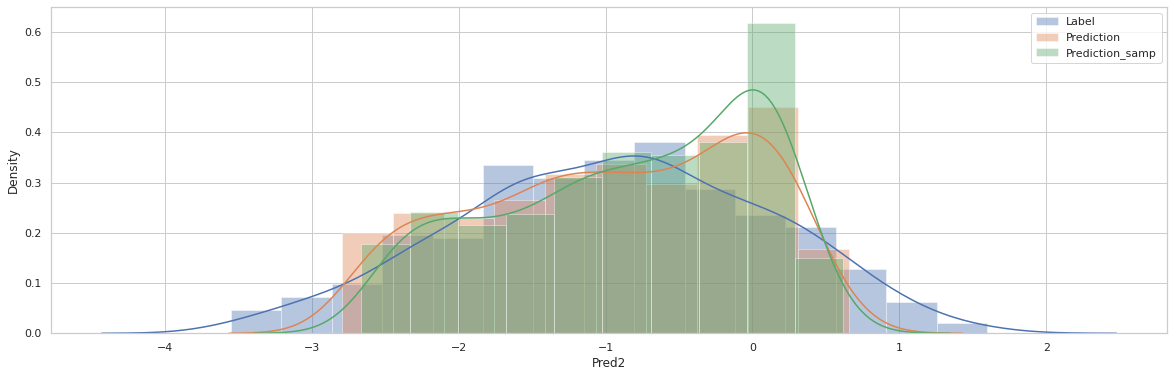

In [10]:
preds_df = pd.DataFrame({'Label': y_true, 'Pred': y_preds[:,0], 'Pred2': y_preds2[:,0]})

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(preds_df['Label'], ax=ax, label='Label')
sns.distplot(preds_df['Pred'], ax=ax, label='Prediction')
sns.distplot(preds_df['Pred2'], ax=ax, label='Prediction_samp')
ax.legend()
plt.show()

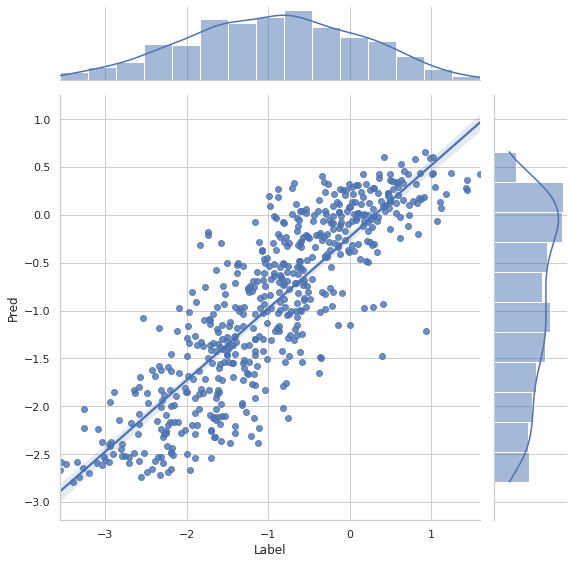

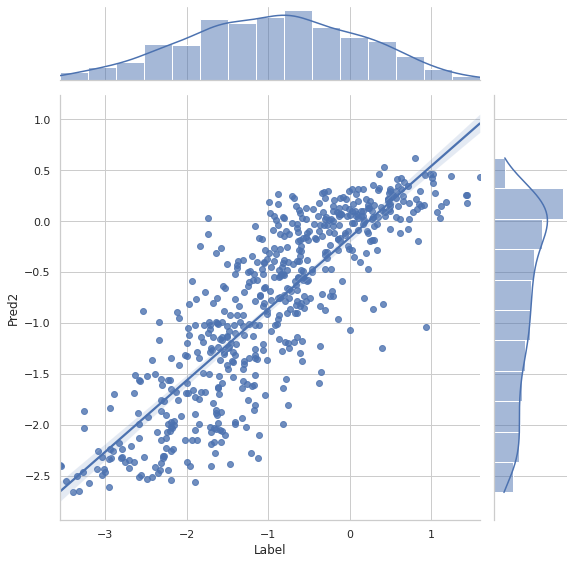

In [11]:
sns.jointplot(data=preds_df, x='Label', y='Pred', kind='reg', height=8)
plt.show()
sns.jointplot(data=preds_df, x='Label', y='Pred2', kind='reg', height=8)
plt.show()